In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from load_mnist import load_mnist



from torch.utils.data import DataLoader, ConcatDataset
from collections import OrderedDict
from functools import partial
from adjustText import adjust_text
import pickle
from pathlib import Path
from time import time

In [2]:
DATA_PATH = '../dataset/fashion_mnist'

In [3]:
# classifier

def FashionMNISTClassifier(num_neurons, activation_type=nn.Identity):
    layers = [nn.Flatten(1)]
    last_layer_neurons = 28*28

    for i, layer_neurons in enumerate(num_neurons):
        layers.append(nn.Linear(last_layer_neurons, layer_neurons))
        layers.append(activation_type())
        last_layer_neurons = layer_neurons

    layers.append(nn.Linear(last_layer_neurons, 10))
    return nn.Sequential(*layers)

In [4]:
class Dataset:
    def __init__(self, dataset, filter_class=None, sort=False):
        self.imgs, self.labels = load_mnist(dataset=dataset, path=DATA_PATH)
        self.imgs = self.imgs.flatten(1)
        self.labels = self.labels.long()
        
        
        self.mean = self.imgs.mean(dim=0)
        self.std = self.imgs.std(dim=0)
        # self.std, self.mean = torch.std_mean(self.images, dim=0)
    
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        img = (self.imgs[index] - self.mean) / (self.std + 1e-10)
        return img, self.labels[index]


"# load datasets\ntrain_images, train_labels = load_mnist(dataset='training', path=DATA_PATH)\ntest_images, test_labels = load_mnist(dataset='testing', path=DATA_PATH)\n\ntest_dataloader = torch.utils.data.DataLoader(Dataset('testing'), batch_size=32, shuffle=True)"

In [5]:
def train(model, dataloader, criterion, optimizer):
    for i, (img_batch, label_batch) in enumerate(dataloader):
        optimizer.zero_grad()
        predictions = model(img_batch)
        loss = criterion(predictions, label_batch)       
        loss.backward()
        optimizer.step()


In [59]:
def predict(model, images):
    predictions = model(images)
    predictions = torch.argmax(predictions, dim=1)
    return predictions

def accuracy(model, dataloader):
    hits = total = 0
    for image_batch, label_batch in dataloader:
        predictions = predict(model, image_batch)
        hits += (predictions == label_batch).count_nonzero()
        total += len(image_batch)
    return hits / total 

def getGradient(model):
    gradients_of_layers = []
    for i in range(3, len(model), 2):
        gradients_of_layers.append(model[i].weight.grad.norm())
    return gradients_of_layers

In [81]:
# common training defs
test_dataloader = DataLoader(Dataset('testing'), batch_size=64, shuffle=False)

def run_training_method(dataloaders, epochs_per_dataloader, num_neurons, activation=nn.Sigmoid, initialization=None):
    model = FashionMNISTClassifier(num_neurons=num_neurons, activation_type=activation)    
    if initialization != None:
        model.apply(initialization)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.005)
    
    accuracies = []
    gradients = []
    
    for dataloader, num_epochs in zip(dataloaders, epochs_per_dataloader):
        for epoch in range(num_epochs):
            train(model, dataloader, criterion, optimizer)
            accuracies.append(accuracy(model, test_dataloader))
            gradients.append(getGradient(model))
            print(f"epoch {epoch}, accuracy={accuracies[-1]:.4f}")
        print("---")
        
    return accuracies, gradients

# (a) Train the classes separately. i.e. filter the dataset and train for five epochs on all images depicting a 0, then on all imgs depicting a 1, and so on

In [71]:
def plotGradients(gradients, num_neurons):
    num_layers = np.array(gradients).shape[1]
    plt.figure(figsize=(10,6))
    for i in range(num_layers): 
        gradients_layer = np.array(gradients)[:,i]
        plt.plot(gradients_layer, label="hidden layer "+str(i+1))
        plt.title(str(num_neurons))
    plt.legend()
    plt.show()
        

# 1 Plot accuracy and norm of gradient

epoch 0, accuracy=0.6812
epoch 1, accuracy=0.7253
epoch 2, accuracy=0.7467
epoch 3, accuracy=0.7605
epoch 4, accuracy=0.7727
epoch 5, accuracy=0.7814
epoch 6, accuracy=0.7918
epoch 7, accuracy=0.8006
epoch 8, accuracy=0.8047
epoch 9, accuracy=0.8104
epoch 10, accuracy=0.8146
epoch 11, accuracy=0.8172
epoch 12, accuracy=0.8207
epoch 13, accuracy=0.8235
epoch 14, accuracy=0.8264
epoch 15, accuracy=0.8285
epoch 16, accuracy=0.8290
epoch 17, accuracy=0.8309
epoch 18, accuracy=0.8332
epoch 19, accuracy=0.8333
---


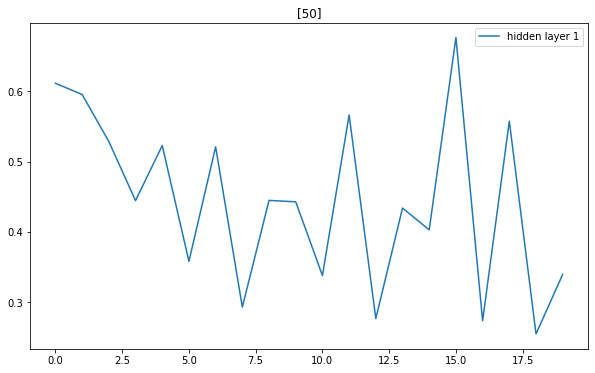

epoch 0, accuracy=0.3642
epoch 1, accuracy=0.5313
epoch 2, accuracy=0.5142
epoch 3, accuracy=0.5460
epoch 4, accuracy=0.5580
epoch 5, accuracy=0.5693
epoch 6, accuracy=0.6067
epoch 7, accuracy=0.6187
epoch 8, accuracy=0.6417
epoch 9, accuracy=0.6548
epoch 10, accuracy=0.6561
epoch 11, accuracy=0.6652
epoch 12, accuracy=0.6820
epoch 13, accuracy=0.6871
epoch 14, accuracy=0.6955
epoch 15, accuracy=0.7171
epoch 16, accuracy=0.7301
epoch 17, accuracy=0.7395
epoch 18, accuracy=0.7454
epoch 19, accuracy=0.7500
---


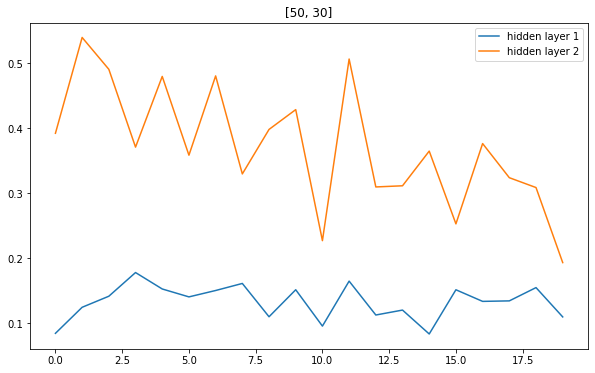

epoch 0, accuracy=0.1022
epoch 1, accuracy=0.1025
epoch 2, accuracy=0.1000
epoch 3, accuracy=0.2691
epoch 4, accuracy=0.2152
epoch 5, accuracy=0.1059
epoch 6, accuracy=0.1952
epoch 7, accuracy=0.2404
epoch 8, accuracy=0.2284
epoch 9, accuracy=0.3042
epoch 10, accuracy=0.2147
epoch 11, accuracy=0.1901
epoch 12, accuracy=0.2002
epoch 13, accuracy=0.1998
epoch 14, accuracy=0.2111
epoch 15, accuracy=0.2181
epoch 16, accuracy=0.2553
epoch 17, accuracy=0.2419
epoch 18, accuracy=0.2592
epoch 19, accuracy=0.2774
---


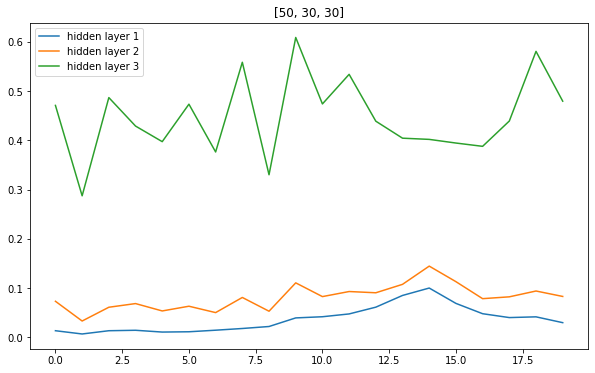

epoch 0, accuracy=0.1000
epoch 1, accuracy=0.1000
epoch 2, accuracy=0.1000
epoch 3, accuracy=0.1000
epoch 4, accuracy=0.1000
epoch 5, accuracy=0.1000
epoch 6, accuracy=0.1000
epoch 7, accuracy=0.1000
epoch 8, accuracy=0.1000
epoch 9, accuracy=0.1000
epoch 10, accuracy=0.1000
epoch 11, accuracy=0.1000
epoch 12, accuracy=0.1000
epoch 13, accuracy=0.1000
epoch 14, accuracy=0.1000
epoch 15, accuracy=0.1000
epoch 16, accuracy=0.1253
epoch 17, accuracy=0.1000
epoch 18, accuracy=0.1000
epoch 19, accuracy=0.1000
---


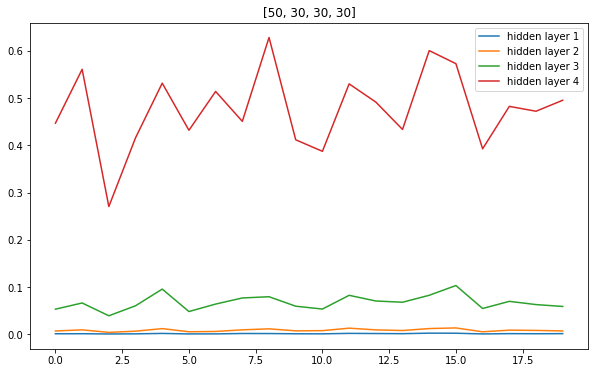

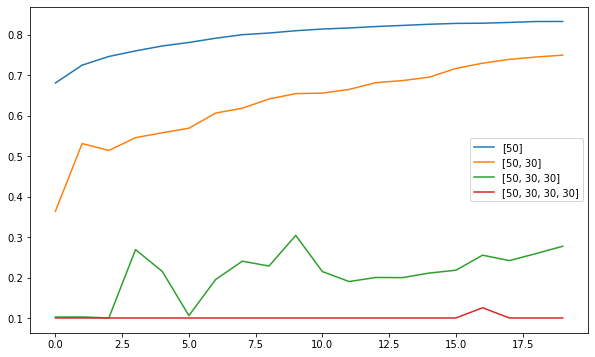

In [76]:
config = [[50], [50, 30], [50, 30, 30], [50, 30, 30, 30]]
# training method 1: per class training
dataloaders = [DataLoader(Dataset('training'), batch_size=64, shuffle=True)]

accuracies_diff_config = []

for num_neurons in config:
    accuracies, gradients = run_training_method(dataloaders=dataloaders, 
                                                epochs_per_dataloader=[20],
                                                num_neurons=num_neurons, 
                                                activation=nn.Sigmoid)
    accuracies_diff_config.append(accuracies)
    plotGradients(gradients, num_neurons)
    
plt.figure(figsize=(10,6))
for i in range(len(accuracies_diff_config)):
    # plot results    
    plt.plot(accuracies_diff_config[i], label=str(config[i]))
plt.legend()
plt.show()
    

# 3 with Using ReLU

Here we can see that with ReLU, the norm of gradient of different layers are more similar.
Also the model with multiple layers perform way better in accuracy with ReLU

epoch 0, accuracy=0.7773
epoch 1, accuracy=0.8097
epoch 2, accuracy=0.8247
epoch 3, accuracy=0.8329
epoch 4, accuracy=0.8357
epoch 5, accuracy=0.8401
epoch 6, accuracy=0.8434
epoch 7, accuracy=0.8461
epoch 8, accuracy=0.8485
epoch 9, accuracy=0.8502
epoch 10, accuracy=0.8522
epoch 11, accuracy=0.8554
epoch 12, accuracy=0.8562
epoch 13, accuracy=0.8566
epoch 14, accuracy=0.8573
epoch 15, accuracy=0.8596
epoch 16, accuracy=0.8604
epoch 17, accuracy=0.8623
epoch 18, accuracy=0.8621
epoch 19, accuracy=0.8636
---


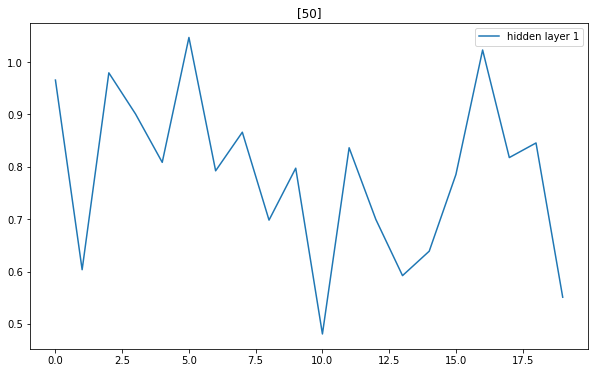

epoch 0, accuracy=0.7410
epoch 1, accuracy=0.7795
epoch 2, accuracy=0.8011
epoch 3, accuracy=0.8198
epoch 4, accuracy=0.8306
epoch 5, accuracy=0.8386
epoch 6, accuracy=0.8413
epoch 7, accuracy=0.8441
epoch 8, accuracy=0.8495
epoch 9, accuracy=0.8509
epoch 10, accuracy=0.8544
epoch 11, accuracy=0.8559
epoch 12, accuracy=0.8581
epoch 13, accuracy=0.8579
epoch 14, accuracy=0.8617
epoch 15, accuracy=0.8627
epoch 16, accuracy=0.8641
epoch 17, accuracy=0.8656
epoch 18, accuracy=0.8675
epoch 19, accuracy=0.8669
---


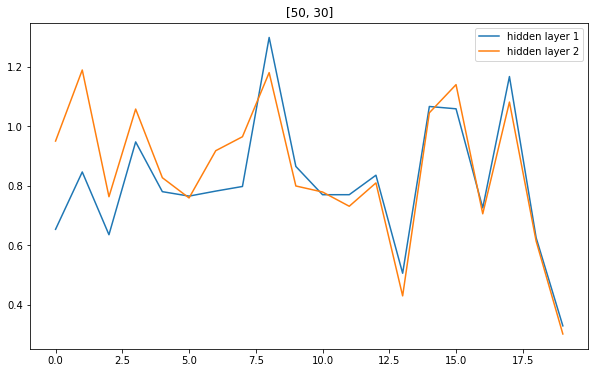

epoch 0, accuracy=0.6430
epoch 1, accuracy=0.7411
epoch 2, accuracy=0.7732
epoch 3, accuracy=0.7987
epoch 4, accuracy=0.8140
epoch 5, accuracy=0.8244
epoch 6, accuracy=0.8318
epoch 7, accuracy=0.8381
epoch 8, accuracy=0.8433
epoch 9, accuracy=0.8477
epoch 10, accuracy=0.8498
epoch 11, accuracy=0.8540
epoch 12, accuracy=0.8544
epoch 13, accuracy=0.8572
epoch 14, accuracy=0.8581
epoch 15, accuracy=0.8582
epoch 16, accuracy=0.8611
epoch 17, accuracy=0.8646
epoch 18, accuracy=0.8610
epoch 19, accuracy=0.8640
---


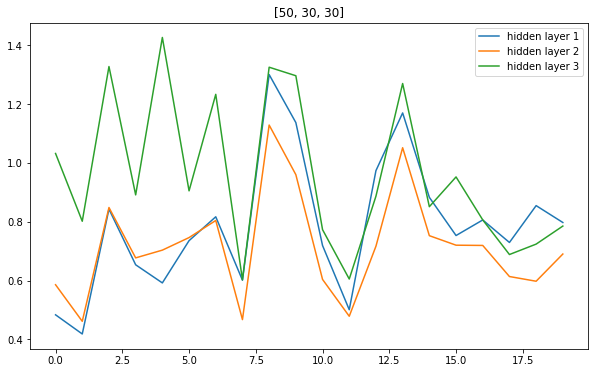

epoch 0, accuracy=0.3231
epoch 1, accuracy=0.6332
epoch 2, accuracy=0.7394
epoch 3, accuracy=0.7708
epoch 4, accuracy=0.7803
epoch 5, accuracy=0.7944
epoch 6, accuracy=0.8170
epoch 7, accuracy=0.8319
epoch 8, accuracy=0.8379
epoch 9, accuracy=0.8431
epoch 10, accuracy=0.8488
epoch 11, accuracy=0.8516
epoch 12, accuracy=0.8571
epoch 13, accuracy=0.8592
epoch 14, accuracy=0.8623
epoch 15, accuracy=0.8626
epoch 16, accuracy=0.8635
epoch 17, accuracy=0.8647
epoch 18, accuracy=0.8652
epoch 19, accuracy=0.8678
---


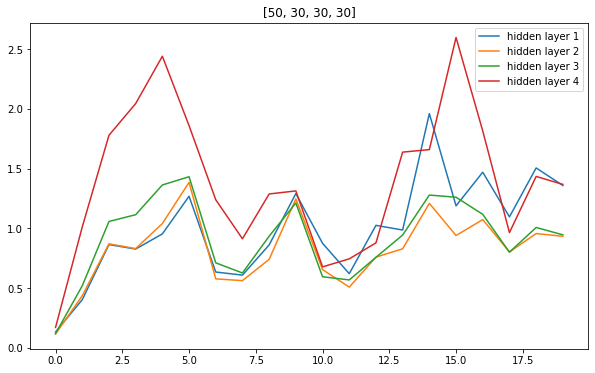

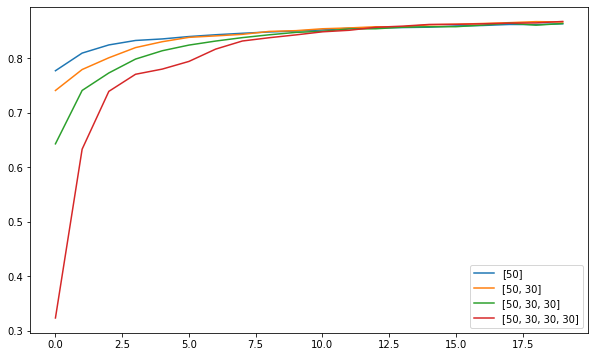

In [77]:
config = [[50], [50, 30], [50, 30, 30], [50, 30, 30, 30]]
# training method 1: per class training
dataloaders = [DataLoader(Dataset('training'), batch_size=64, shuffle=True)]

accuracies_diff_config = []

for num_neurons in config:
    accuracies, gradients = run_training_method(dataloaders=dataloaders, 
                                                epochs_per_dataloader=[20],
                                                num_neurons=num_neurons, 
                                                activation=nn.ReLU)
    accuracies_diff_config.append(accuracies)
    plotGradients(gradients, num_neurons)
    
plt.figure(figsize=(10,6))
for i in range(len(accuracies_diff_config)):
    # plot results    
    plt.plot(accuracies_diff_config[i], label=str(config[i]))
plt.legend()
plt.show()

# 4 Initialize with xavier_normal

In [82]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)

epoch 0, accuracy=0.7324
epoch 1, accuracy=0.7636
epoch 2, accuracy=0.7783
epoch 3, accuracy=0.7906
epoch 4, accuracy=0.7985
epoch 5, accuracy=0.8050
epoch 6, accuracy=0.8104
epoch 7, accuracy=0.8137
epoch 8, accuracy=0.8175
epoch 9, accuracy=0.8215
epoch 10, accuracy=0.8236
epoch 11, accuracy=0.8263
epoch 12, accuracy=0.8300
epoch 13, accuracy=0.8308
epoch 14, accuracy=0.8316
epoch 15, accuracy=0.8331
epoch 16, accuracy=0.8341
epoch 17, accuracy=0.8355
epoch 18, accuracy=0.8368
epoch 19, accuracy=0.8378
---


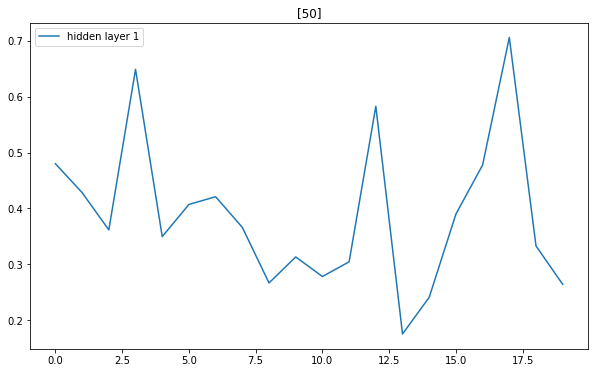

epoch 0, accuracy=0.5903
epoch 1, accuracy=0.6324
epoch 2, accuracy=0.6464
epoch 3, accuracy=0.6809
epoch 4, accuracy=0.7107
epoch 5, accuracy=0.7238
epoch 6, accuracy=0.7269
epoch 7, accuracy=0.7361
epoch 8, accuracy=0.7399
epoch 9, accuracy=0.7434
epoch 10, accuracy=0.7489
epoch 11, accuracy=0.7552
epoch 12, accuracy=0.7583
epoch 13, accuracy=0.7616
epoch 14, accuracy=0.7672
epoch 15, accuracy=0.7717
epoch 16, accuracy=0.7770
epoch 17, accuracy=0.7788
epoch 18, accuracy=0.7837
epoch 19, accuracy=0.7864
---


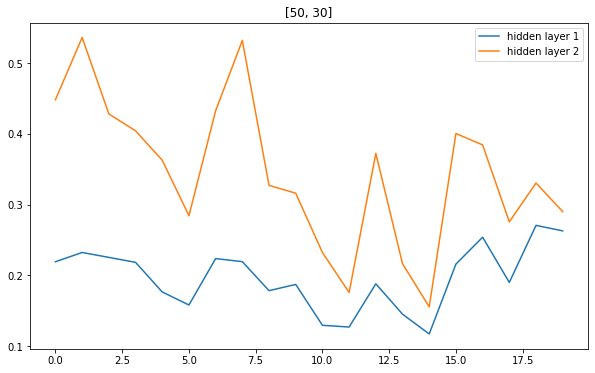

epoch 0, accuracy=0.3098
epoch 1, accuracy=0.3018
epoch 2, accuracy=0.3306
epoch 3, accuracy=0.3303
epoch 4, accuracy=0.3508
epoch 5, accuracy=0.3247
epoch 6, accuracy=0.3936
epoch 7, accuracy=0.4450
epoch 8, accuracy=0.4738
epoch 9, accuracy=0.5559
epoch 10, accuracy=0.5686
epoch 11, accuracy=0.6285
epoch 12, accuracy=0.6214
epoch 13, accuracy=0.6403
epoch 14, accuracy=0.6494
epoch 15, accuracy=0.6525
epoch 16, accuracy=0.6613
epoch 17, accuracy=0.6718
epoch 18, accuracy=0.6790
epoch 19, accuracy=0.6839
---


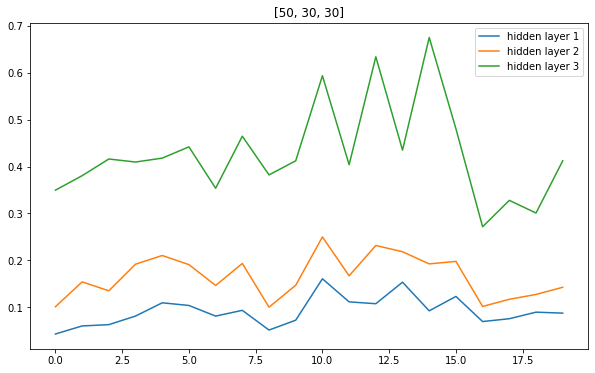

epoch 0, accuracy=0.1001
epoch 1, accuracy=0.0959
epoch 2, accuracy=0.1634
epoch 3, accuracy=0.2630
epoch 4, accuracy=0.2899
epoch 5, accuracy=0.2188
epoch 6, accuracy=0.3417
epoch 7, accuracy=0.2504
epoch 8, accuracy=0.2845
epoch 9, accuracy=0.3032
epoch 10, accuracy=0.2932
epoch 11, accuracy=0.2604
epoch 12, accuracy=0.2897
epoch 13, accuracy=0.3120
epoch 14, accuracy=0.2853
epoch 15, accuracy=0.3046
epoch 16, accuracy=0.2762
epoch 17, accuracy=0.3489
epoch 18, accuracy=0.3749
epoch 19, accuracy=0.3798
---


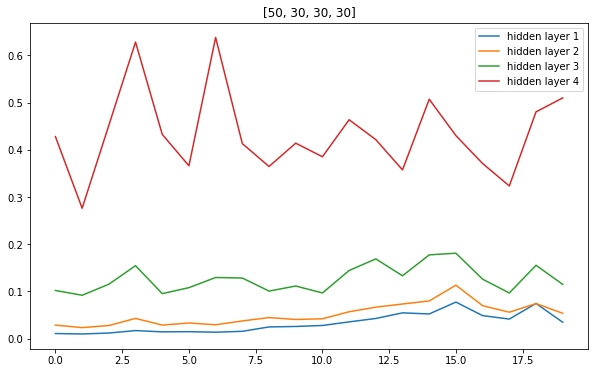

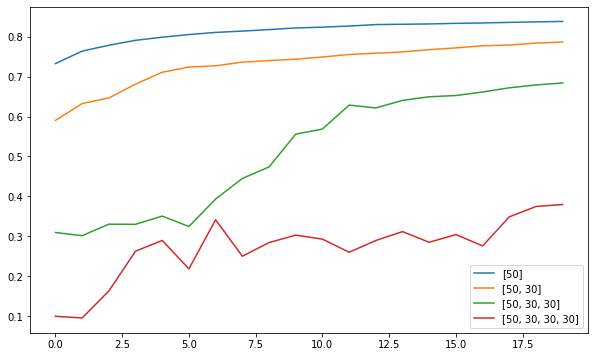

In [83]:
accuracies_diff_config = []

for num_neurons in config:
    accuracies, gradients = run_training_method(dataloaders=dataloaders, 
                                                epochs_per_dataloader=[20],
                                                num_neurons=num_neurons, 
                                                activation=nn.Sigmoid,
                                                initialization=init_weights)
    accuracies_diff_config.append(accuracies)
    plotGradients(gradients, num_neurons)
    
plt.figure(figsize=(10,6))
for i in range(len(accuracies_diff_config)):
    # plot results    
    plt.plot(accuracies_diff_config[i], label=str(config[i]))
plt.legend()
plt.show()